In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from time import perf_counter
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
df = pd.read_csv(r'C:\Users\mgman\Downloads\Emails\spam_ham_dataset.csv')
df.drop('Unnamed: 0', axis=1, inplace = True)
df.columns = ['Label', 'Text', 'Label_Number']
#df = pd.read_excel(r'C:\Users\mgman\Downloads\Emails\All_Emails.xlsx', sheet_name='Sheet1')
#df.drop('ID', axis=1, inplace = True)
df.head()

,Label,Text,Label_Number
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [4]:
df.shape

(5171, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Label         5171 non-null   object
 1   Text          5171 non-null   object
 2   Label_Number  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [6]:
df.isna().sum()

Label           0
Text            0
Label_Number    0
dtype: int64

In [7]:
df['Label_Number'].value_counts()

0    3672
1    1499
Name: Label_Number, dtype: int64

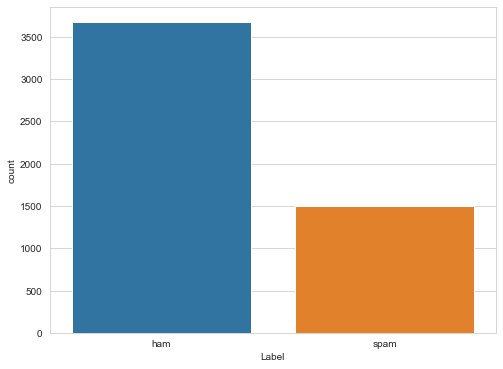

In [8]:
plt.figure(figsize = (8, 6))
sns.countplot(data = df, x = 'Label');

In [9]:
def count_words(text):
    words = word_tokenize(text)
    return len(words)
df['count']=df['Text'].apply(count_words)
df['count']

0        68
1        24
2       551
3        49
4        71
       ... 
5166    156
5167    306
5168     79
5169    112
5170    200
Name: count, Length: 5171, dtype: int64

In [10]:
df.groupby('Label_Number')['count'].mean()

Label_Number
0    226.239107
1    236.387592
Name: count, dtype: float64

In [11]:
%%time
def clean_str(string, reg = RegexpTokenizer(r'[a-z]+')):
    # Clean a string with RegexpTokenizer
    string = string.lower()
    tokens = reg.tokenize(string)
    return " ".join(tokens)

print('Before cleaning:')
df.head()

Before cleaning:
Wall time: 997 µs


,Label,Text,Label_Number,count
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,68
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,24
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,551
3,spam,"Subject: photoshop , windows , office . cheap ...",1,49
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,71


In [12]:
print('After cleaning:')
df['Text'] = df['Text'].apply(lambda string: clean_str(string))
df.head()

After cleaning:


,Label,Text,Label_Number,count
0,ham,subject enron methanol meter this is a follow ...,0,68
1,ham,subject hpl nom for january see attached file ...,0,24
2,ham,subject neon retreat ho ho ho we re around to ...,0,551
3,spam,subject photoshop windows office cheap main tr...,1,49
4,ham,subject re indian springs this deal is to book...,0,71


In [13]:
df["Text"] = [' '.join([item for item in x.split() 
                  if item not in 'subject']) 
                  for x in df["Text"]]
df.head()

,Label,Text,Label_Number,count
0,ham,enron methanol meter this is a follow up to th...,0,68
1,ham,hpl nom for january see attached file hplnol x...,0,24
2,ham,neon retreat ho ho ho we re around to that mos...,0,551
3,spam,photoshop windows office cheap main trending a...,1,49
4,ham,re indian springs this deal is to book the tec...,0,71


In [14]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
def stemming (text):
    return ''.join([stemmer.stem(word) for word in text])
df['Text']=df['Text'].apply(stemming)
df.head()

,Label,Text,Label_Number,count
0,ham,enron methanol meter this is a follow up to th...,0,68
1,ham,hpl nom for january see attached file hplnol x...,0,24
2,ham,neon retreat ho ho ho we re around to that mos...,0,551
3,spam,photoshop windows office cheap main trending a...,1,49
4,ham,re indian springs this deal is to book the tec...,0,71


In [15]:
X = df.loc[:, 'Text']
y = df.loc[:, 'Label_Number']

print(f"Shape of X: {X.shape}\nshape of y: {y.shape}")

Shape of X: (5171,)
shape of y: (5171,)


In [16]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(df.Text)
y = df.Label

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
models = {
    "Random Forest": {"model":RandomForestClassifier(), "perf":0},
    "Gradient Boosting": {"model":GradientBoostingClassifier(), "perf":0},
    "MultinomialNB": {"model":MultinomialNB(), "perf":0},
    "Logistic Regr.": {"model":LogisticRegression(), "perf":0},
    "KNN": {"model":KNeighborsClassifier(), "perf":0},
    "Decision Tree": {"model":DecisionTreeClassifier(), "perf":0},
    "SVM (Linear)": {"model":LinearSVC(), "perf":0},
    "SVM (RBF)": {"model":SVC(), "perf":0}
}

for name, model in models.items():
    start = perf_counter()
    model['model'].fit(X_train, y_train)
    duration = perf_counter() - start
    duration = round(duration,2)
    model["perf"] = duration
    print(f"{name:20} trained in {duration} sec")


Random Forest        trained in 15.03 sec
Gradient Boosting    trained in 55.95 sec
MultinomialNB        trained in 0.03 sec
Logistic Regr.       trained in 1.5 sec
KNN                  trained in 0.01 sec
Decision Tree        trained in 1.99 sec
SVM (Linear)         trained in 0.52 sec
SVM (RBF)            trained in 10.8 sec


In [18]:
models_accuracy = []
for name, model in models.items():
    models_accuracy.append([name, model["model"].score(X_test, y_test),model["perf"]])
models_accuracy1 = []
for name, model in models.items():
    models_accuracy1.append([name, model["model"].score(X_train, y_train),model["perf"]])

In [19]:
df_accuracy = pd.DataFrame(models_accuracy)
df_accuracy.columns = ['Model', 'Test Accuracy', 'Training time (sec)']
df_accuracy.sort_values(by = 'Test Accuracy', ascending = False, inplace=True)
df_accuracy.reset_index(drop = True, inplace=True)
df_accuracy

,Model,Test Accuracy,Training time (sec)
0,MultinomialNB,0.973913,0.03
1,Logistic Regr.,0.973913,1.50
2,Random Forest,0.971014,15.03
3,SVM (Linear),0.963285,0.52
4,Gradient Boosting,0.959420,55.95
5,Decision Tree,0.958454,1.99
6,SVM (RBF),0.956522,10.80
7,KNN,0.867633,0.01


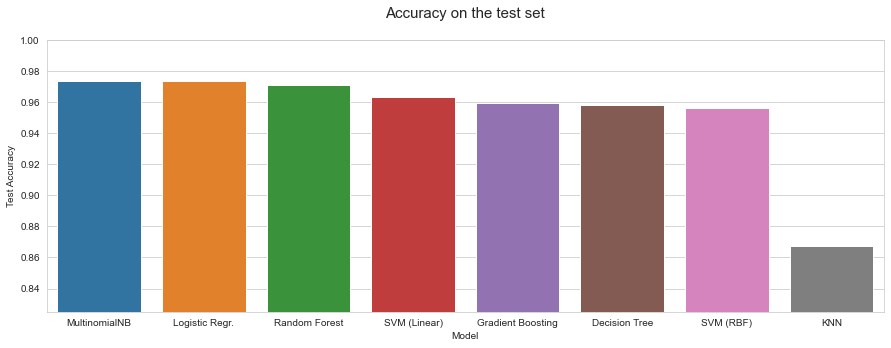

In [20]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Model', y ='Test Accuracy', data = df_accuracy)
plt.title('Accuracy on the test set\n', fontsize = 15)
plt.ylim(0.825,1)
plt.show()

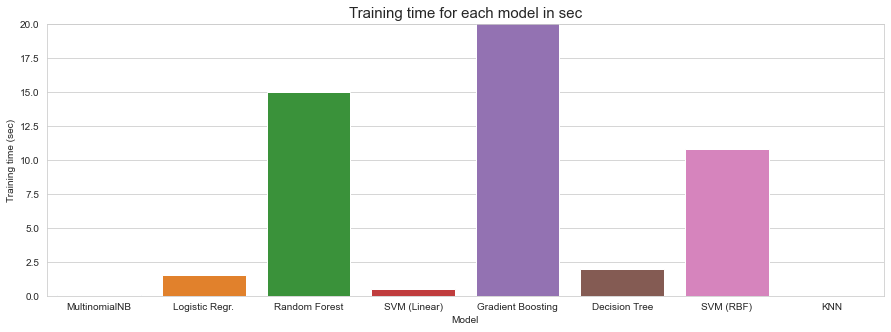

In [21]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Model', y = 'Training time (sec)', data = df_accuracy)
plt.title('Training time for each model in sec', fontsize = 15)
plt.ylim(0,20)
plt.show()

MutinomialNB gives the best results in terms of both the training tone and the Test Accuracy

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
parameters = {"alpha": [0.2,1,2,5,10], "fit_prior": [True, False]}

grid = GridSearchCV(MultinomialNB(), param_grid=parameters)
grid.fit(X_train,y_train)

# Create a DataFrame with the best Hyperparameters
pd.DataFrame(grid.cv_results_)[['params','mean_test_score']]\
                               .sort_values(by="mean_test_score", ascending=False)

,params,mean_test_score
0,"{'alpha': 0.2, 'fit_prior': True}",0.981625
1,"{'alpha': 0.2, 'fit_prior': False}",0.981384
3,"{'alpha': 1, 'fit_prior': False}",0.980899
2,"{'alpha': 1, 'fit_prior': True}",0.978240
5,"{'alpha': 2, 'fit_prior': False}",0.972197
4,"{'alpha': 2, 'fit_prior': True}",0.967845
7,"{'alpha': 5, 'fit_prior': False}",0.937141
6,"{'alpha': 5, 'fit_prior': True}",0.931096
9,"{'alpha': 10, 'fit_prior': False}",0.890478
8,"{'alpha': 10, 'fit_prior': True}",0.881290


In [25]:
grid.best_params_

{'alpha': 0.2, 'fit_prior': True}

In [27]:
from sklearn.naive_bayes import MultinomialNB
alpha, fit_prior = grid.best_params_['alpha'], grid.best_params_['fit_prior']
model = MultinomialNB(alpha = alpha)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score
print(f'## Accuracy: {round(accuracy_score(y_test,y_pred),3)*100}%\n')

## Accuracy: 97.5%



In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       732
        spam       0.96      0.96      0.96       303

    accuracy                           0.97      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035



In [33]:
def display_result(df, number=2):
    for i in range(number):
        msg = df['Text'].iloc[i]
        label = df["Label"].iloc[i]
        msg_vec = cv.transform([msg])
        pred_label = model.predict(msg_vec)
        print(f"**Real: {label}, Predicted: {pred_label[0]}**")
        print(f"**E-Mail:** {msg}")
        print("_______________________________________________________________")
    
df_spam = df[df['Label'] == 'spam']
df_ham = df[df['Label'] == 'ham']
display_result(df_spam)
display_result(df_ham)

**Real: spam, Predicted: spam**
**E-Mail:** photoshop windows office cheap main trending abasements darer prudently fortuitous undergone lighthearted charm orinoco taster railroad affluent pornographic cuvier irvin parkhouse blameworthy chlorophyll robed diagrammatic fogarty clears bayda inconveniencing managing represented smartness hashish academies shareholders unload badness danielson pure caffein spaniard chargeable levin
_______________________________________________________________
**Real: spam, Predicted: spam**
**E-Mail:** looking for medication we re the best source it is difficult to make our material condition better by the best law but it is easy enough to ruin it by bad laws excuse me you just found the best and simpliest site for medication on the net no perscription easy delivery private secure and easy better see rightly on a pound a week than squint on a million we ve got anything that you will ever want erection treatment pills anti depressant pills weight loss and 